In [2]:
import numpy as np
import pandas as pd

path = "avg/"
sub_path = "no-d7/0-dmsp.xlsx"

host_path = "data/algae/" + path + sub_path
bacteria_path = "data/bacteria/" + path + sub_path

df_host = pd.read_excel(host_path, header=None)
df_bacteria = pd.read_excel(bacteria_path, header=None)
df_bacteria = df_bacteria.replace(0, np.nan)

df_host_time = df_host.iloc[:, 0]
host = df_host.iloc[:, 1].tolist()

df_bacteria_time = df_bacteria.iloc[:, 0]
bacteria = df_bacteria.iloc[:, 1].tolist()

time = df_host_time.tolist()
#time = time[1:]

log_host = np.log(np.array(host) + 1e-9)
log_bacteria = np.log(np.array(bacteria) + 1e-9)

save_path = "figures/0-path/" + host_path.replace("/", "_")
save_path = save_path[:-5].replace("data_algae_", "").strip()


In [3]:
def ode_system(t, y, params):
    H = y[0]
    B = y[1]

    muH = params[0]
    muB = params[1]
    k = params[2]

    dHdt = (muH * H * (1 - (H / k) ))
    dBdt = muB * B
    return [dHdt, dBdt]

In [4]:
import pytensor.tensor as pt
from pytensor.graph.op import Op
from scipy.integrate import solve_ivp

class SolveIVPWrapper(Op):
    itypes = [pt.dvector]  # theta + y0
    otypes = [pt.dmatrix]  # solution: (len(t), 3)

    def __init__(self, times):
        self.times = times

    def perform(self, node, inputs, outputs):
        theta_y0, = inputs
        theta = theta_y0[:3] # first 3
        y0 = theta_y0[3:] # last 2

        sol = solve_ivp(
            fun=lambda t, y: ode_system(t, y, theta),
            t_span=(self.times[0], self.times[-1]),
            y0=y0,
            t_eval=self.times,
            method="LSODA"
        )

        if not sol.success:
            raise RuntimeError("ODE solver failed:", sol.message)

        outputs[0][0] = sol.y.T  # shape: (time, 3)

In [5]:
import pymc as pm

ode_op = SolveIVPWrapper(time)

with pm.Model() as model:
    muH = pm.Uniform("muH", lower=0, upper=1)
    muB = pm.Uniform("muB", lower=0, upper=1)
    k = pm.Uniform("k", lower=1e6, upper=2e7)

    H0 = pm.Uniform("H0", lower=2e5, upper=1e7)
    B0 = pm.Uniform("B0", lower=2e4, upper=1e7)
    
    sigma_host = pm.HalfNormal("sigma_host", sigma=1)
    sigma_bacteria = pm.HalfNormal("sigma_bacteria", sigma=1)

    ode_solution = ode_op(pt.stack([muH, muB, k, H0, B0]))

    pm.Normal(
        "host_obs",
        mu=pm.math.log(ode_solution[1:, 0] + 1e-9),
        sigma=sigma_host,
        observed=log_host[1:]
    )

    pm.Normal(
        "bacteria_obs",
        mu=pm.math.log(ode_solution[1:, 1] + 1e-9),
        sigma=sigma_bacteria,
        observed=log_bacteria[1:]
    )

In [6]:
with model:
    trace = pm.sample(draws=10000, 
                      tune=10000, 
                      step=pm.Metropolis(),
                      chains=4, 
                      cores=4, 
                      return_inferencedata=True, 
                     ) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [muH]
>Metropolis: [muB]
>Metropolis: [k]
>Metropolis: [H0]
>Metropolis: [B0]
>Metropolis: [sigma_host]
>Metropolis: [sigma_bacteria]


Output()

Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 124 seconds.


In [7]:
with model:
    start = model.initial_point()
    map_point = pm.find_MAP(start=start, progressbar=True)

map_point

Output()

{'muH_interval__': array(-70.83373237),
 'muB_interval__': array(-95.01723877),
 'k_interval__': array(0.),
 'H0_interval__': array(-0.71636456),
 'B0_interval__': array(-3.52974699),
 'sigma_host_log__': array(-0.43057102),
 'sigma_bacteria_log__': array(0.21264061),
 'muH': array(1.72703405e-31),
 'muB': array(5.42672127e-42),
 'k': array(10500000.),
 'H0': array(3416301.53213866),
 'B0': array(304206.31642466),
 'sigma_host': array(0.65013775),
 'sigma_bacteria': array(1.23694002)}

In [8]:
import matplotlib.pyplot as plt
import arviz as az
summary = az.summary(
    trace,
    round_to=10
)
summary.to_csv(save_path + "_summary.csv")
print(summary)
# Take note of ess_bulk and r_hat values

                        mean             sd        hdi_3%       hdi_97%  \
muH             8.764556e-01       0.067235  7.625794e-01  9.998813e-01   
muB             3.352031e-01       0.070413  2.031417e-01  4.542855e-01   
k               5.396985e+06  255526.035459  4.918805e+06  5.860847e+06   
H0              3.063407e+05   46253.598353  2.336283e+05  3.940144e+05   
B0              4.967449e+04   36113.562892  2.001100e+04  9.332181e+04   
sigma_host      1.039950e-01       0.032986  5.615166e-02  1.633133e-01   
sigma_bacteria  7.358859e-01       0.197432  4.374069e-01  1.109127e+00   

                  mcse_mean      mcse_sd     ess_bulk     ess_tail     r_hat  
muH                0.002265     0.001376   949.753904  1579.519003  1.005486  
muB                0.002508     0.002650   952.018833   957.187613  1.003527  
k               4117.211681  4181.567536  3927.237411  5785.665110  1.001653  
H0              1456.695569  1318.908304  1060.897045  2034.588721  1.004141  
B0  

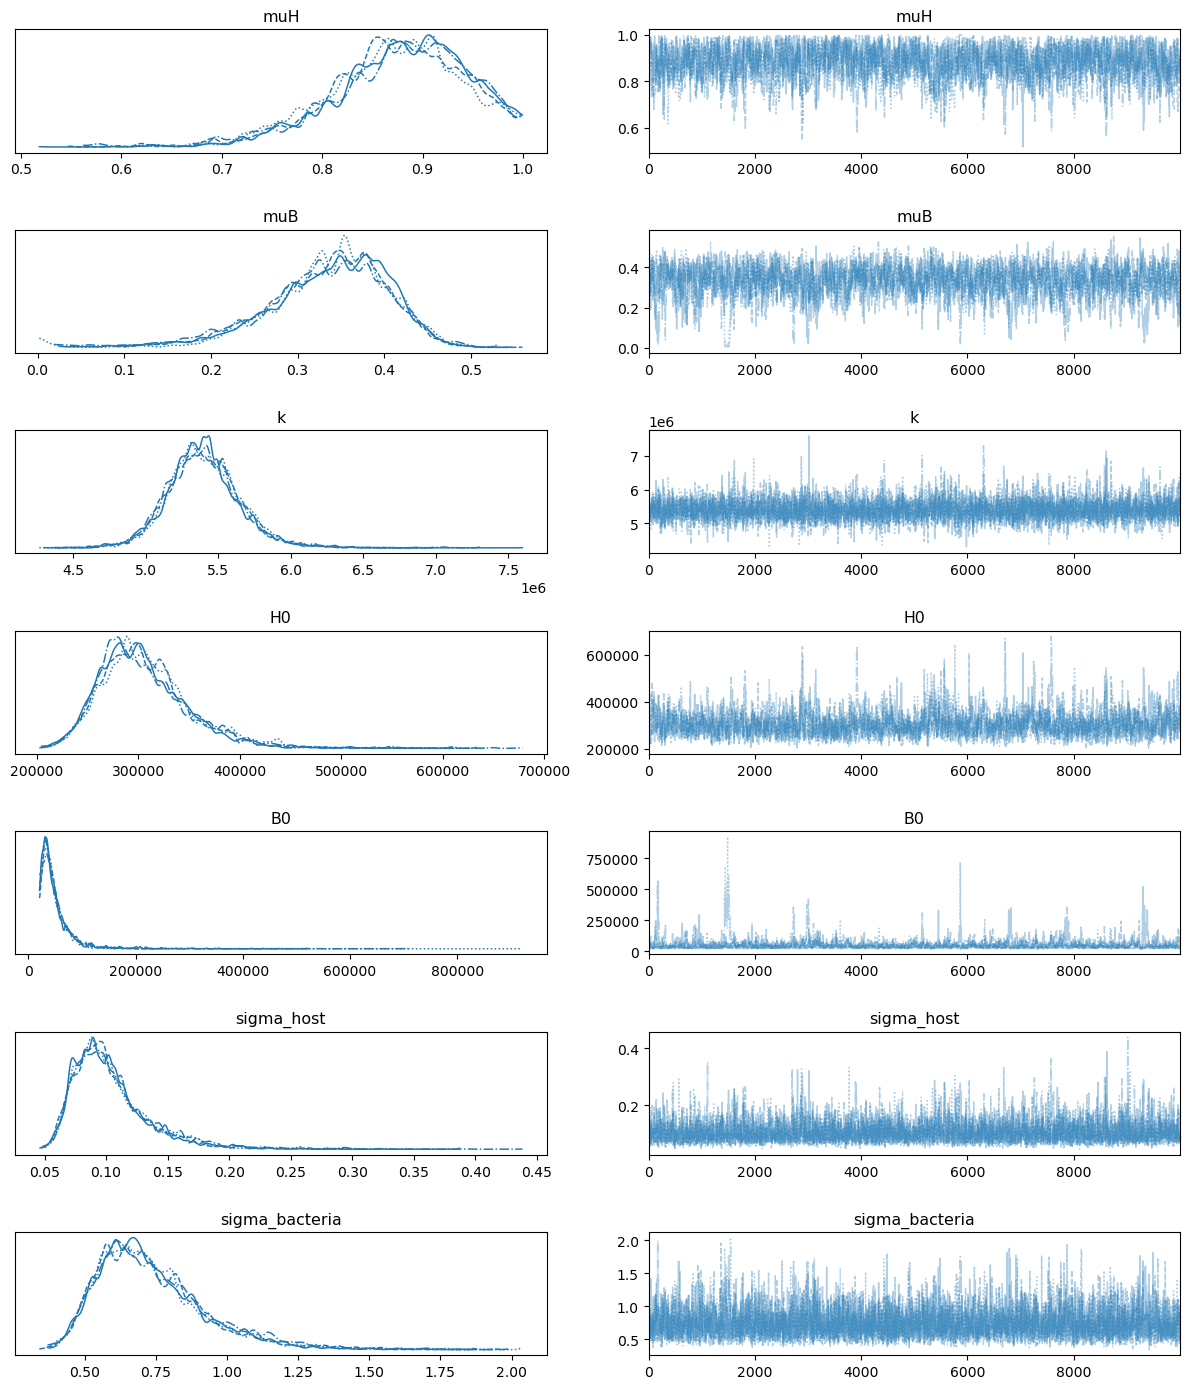

In [9]:
az.plot_trace(trace, 
              backend_kwargs={"tight_layout": True})
plt.savefig(save_path + "-trace.png")
plt.show()

## GPT 5 Induced

In [10]:
def simulate_ode_from_posterior(
    idata,
    time,
    ode_rhs,
    n_draws=100,
    random_seed=None,
):
    import numpy as np
    import arviz as az
    from scipy.integrate import solve_ivp

    rng = np.random.default_rng(random_seed)

    posterior = idata.posterior
    n_chains = posterior.sizes["chain"]
    n_draws_posterior = posterior.sizes["draw"]

    flat_idx = rng.integers(0, n_chains * n_draws_posterior, size=n_draws)
    chain_idx = flat_idx // n_draws_posterior
    draw_idx = flat_idx % n_draws_posterior

    time = np.asarray(time, dtype=float)
    t_span = (time[0], time[-1])

    sims = []

    for c, d in zip(chain_idx, draw_idx):
        muH0 = float(posterior["muH"].values[c, d])
        muB0 = float(posterior["muB"].values[c, d])
        k0      = float(posterior["k"].values[c, d])
        #phi0    = float(posterior["phi"].values[c, d])
        #beta0  = float(posterior["beta"].values[c, d])

        H00 = float(posterior["H0"].values[c, d])
        #P00 = float(posterior["P0"].values[c, d])
        B00 = float(posterior["B0"].values[c, d])

        params_vec = np.array([muH0, muB0, k0], dtype=float)
        y0 = [H00, B00]
        sol = solve_ivp(
            lambda t, y: ode_rhs(t, y, params_vec),
            t_span=t_span,
            y0=y0,
            t_eval=time,
            method="LSODA",   # or whatever stiff solver you like
            rtol=1e-6,
            atol=1e-8,
        )

        if not sol.success:
            sims.append(np.full((time.size, 3), np.nan))
        else:
            sims.append(sol.y.T)

    sims = np.stack(sims, axis=0)  # (n_draws, T, 3)
    return sims


In [11]:
import matplotlib.pyplot as plt

def plot_posterior_fit(
    idata,
    time,
    host,
    #d7,
    bacteria,
    ode_rhs,
    n_draws=200,
    log_scale=True,
    random_seed=None,
):
    """
    Plot posterior ODE trajectories over the observed data
    for Host, D7/Pathogen, and Bacteria.
    """
    time = np.asarray(time, dtype=float)
    host = np.asarray(host, dtype=float)
    #d7 = np.asarray(d7, dtype=float)
    bacteria = np.asarray(bacteria, dtype=float)

    sims = simulate_ode_from_posterior(
        idata,
        time,
        ode_rhs,
        n_draws=n_draws,
        random_seed=random_seed,
    )  # (n_draws, T, 3)

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

    series = [host, bacteria]
    labels = ["Host", "Bacteria"]

    for i, ax in enumerate(axes):
        y_obs = series[i]
        y_sim = sims[:, :, i]  # (n_draws, T)

        if log_scale:
            y_obs_plot = np.log(y_obs + 1e-9)
            y_sim_plot = np.log(y_sim + 1e-9)
            ax.set_ylabel(f"log {labels[i]}")
        else:
            y_obs_plot = y_obs
            y_sim_plot = y_sim
            ax.set_ylabel(labels[i])

        # scatter observed data
        ax.scatter(time, y_obs_plot, marker="o", alpha=0.8)

        # posterior median and 90% band
        median = np.nanmedian(y_sim_plot, axis=0)
        lower, upper = np.nanpercentile(y_sim_plot, [5, 95], axis=0)

        ax.plot(time, median, linewidth=2)
        ax.fill_between(time, lower, upper, alpha=0.2)

        ax.grid(True, alpha=0.3)

    axes[-1].set_xlabel("Time")
    plt.tight_layout()
    return fig, axes


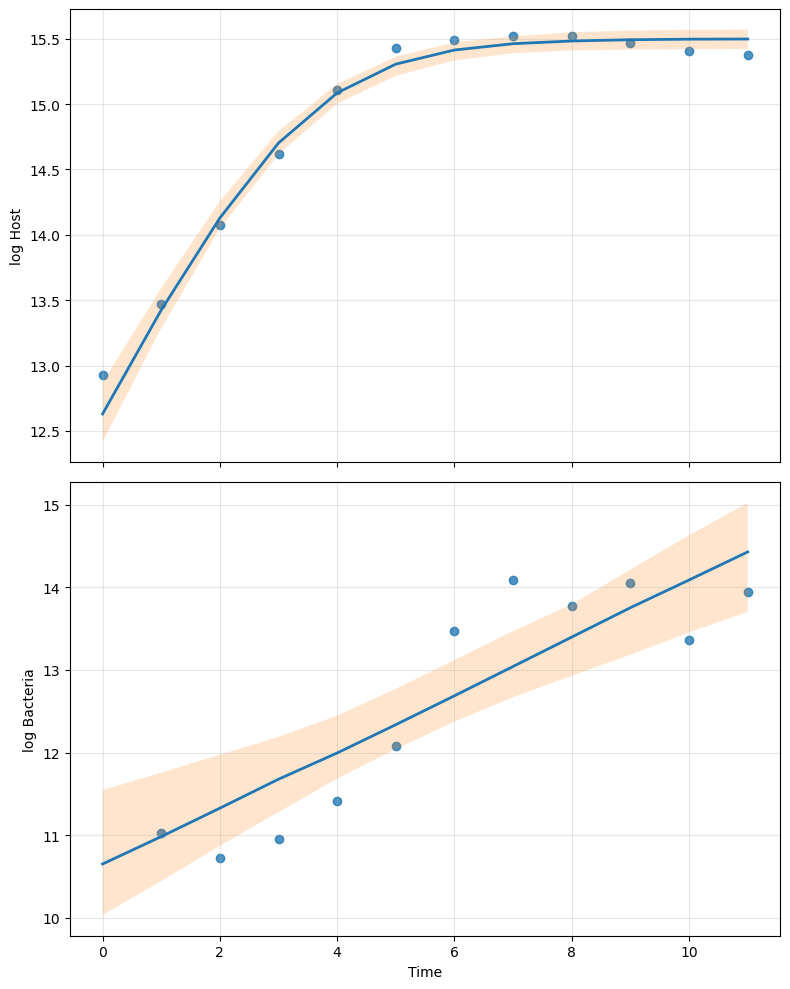

In [12]:
fig, axes = plot_posterior_fit(
    idata=trace,
    time=time,
    host=host,
    bacteria=bacteria,
    ode_rhs=ode_system,
    n_draws=200,
    log_scale=True,
    random_seed=42,
)
plt.savefig(save_path + "-posterior-fit.png")
plt.show()

Output()

Could not compute log_likelihood via pm.compute_log_likelihood: ['log_likelihood'] group(s) already exists.
Best posterior draw:
  chain = 2
  draw  = 4179
  total log-likelihood = 32.77850170969569


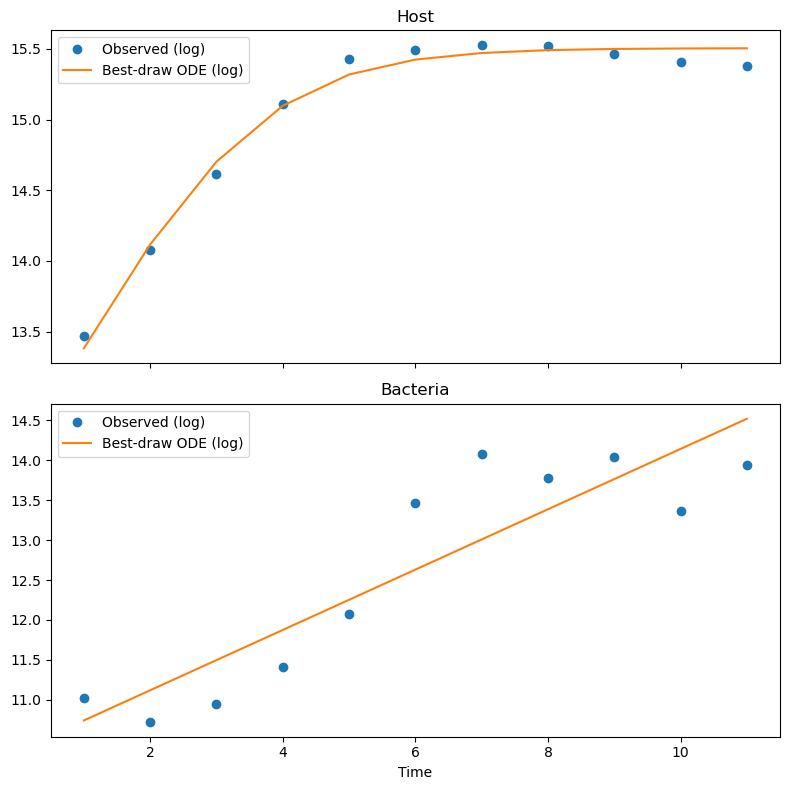

In [15]:
import numpy as np
import pymc as pm

# --- Compute (or attach) pointwise log-likelihood for each posterior draw ---
with model:
    try:
        trace_ll = pm.compute_log_likelihood(trace, model=model)
    except Exception as e:
        trace_ll = trace
        print('Could not compute log_likelihood via pm.compute_log_likelihood:', e)

if not hasattr(trace_ll, 'log_likelihood') or trace_ll.log_likelihood is None:
    raise RuntimeError(
        'log_likelihood is not available on this InferenceData. '
        'If pm.compute_log_likelihood failed, we can fall back to a slower per-draw logp evaluation.'
    )

# Stack all non-(chain, draw) dims and sum to get total log-likelihood per draw
ll = trace_ll.log_likelihood.to_array()  # dims: ('variable','chain','draw', ...)
sum_dims = [d for d in ll.dims if d not in ('variable', 'chain', 'draw')]
total_ll = ll.sum(dim=sum_dims).sum(dim='variable')  # dims: (chain, draw)
'''
stacked = total_ll.stack(sample=('chain','draw'))
best_i = int(stacked.argmax('sample').values)
#best_chain = int(stacked['sample'][best_i].values[0])
#best_draw  = int(stacked['sample'][best_i].values[1])
best_chain, best_draw = stacked['sample'][best_i].values
best_chain = int(best_chain)
best_draw  = int(best_draw)

print('Best posterior draw (by total log-likelihood):')
print('  chain =', best_chain, 'draw =', best_draw)
print('  total_loglik =', float(total_ll.sel(chain=best_chain, draw=best_draw).values))
'''

# total_ll is a DataArray with dims ('chain','draw')
stacked = total_ll.stack(sample=("chain", "draw"))

best_i = int(stacked.argmax("sample").values)  # index along 'sample'

best_chain = int(stacked["chain"].values[best_i])
best_draw  = int(stacked["draw"].values[best_i])

print("Best posterior draw:")
print("  chain =", best_chain)
print("  draw  =", best_draw)
print("  total log-likelihood =", float(stacked.values[best_i]))


# Extract the *joint* parameter vector at that draw (keeps correlations intact)
posterior = trace.posterior
param_names = ['muH','muB','k','H0','B0','sigma_host','sigma_bacteria']
best_params = {}
for name in param_names:
    if name in posterior:
        v = posterior[name].sel(chain=best_chain, draw=best_draw).values
        best_params[name] = float(np.asarray(v))

best_params

# --- Solve ODE once at the best posterior draw and overlay against data ---
from scipy.integrate import solve_ivp

theta = [best_params['muH'], best_params['muB'], best_params['k']]
y0 = [best_params['H0'], best_params['B0']]

sol = solve_ivp(
    fun=lambda t, y: ode_system(t, y, theta),
    t_span=(time[0], time[-1]),
    y0=y0,
    t_eval=np.asarray(time, dtype=float),
    method='LSODA',
)
if not sol.success:
    raise RuntimeError(sol.message)

pred = sol.y.T  # (T, 2)

# Match the model/plotting convention: log + skip the first timepoint
pred_log_host = np.log(pred[1:, 0] + 1e-9)
pred_log_bact = np.log(pred[1:, 1] + 1e-9)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

axes[0].plot(time[1:], log_host[1:], 'o', label='Observed (log)')
axes[0].plot(time[1:], pred_log_host, '-', label='Best-draw ODE (log)')
axes[0].set_title('Host')
axes[0].legend()

axes[1].plot(time[1:], log_bacteria[1:], 'o', label='Observed (log)')
axes[1].plot(time[1:], pred_log_bact, '-', label='Best-draw ODE (log)')
axes[1].set_title('Bacteria')
axes[1].legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pymc as pm

# 1) Ensure log_likelihood exists (compute once)
if "log_likelihood" not in trace.groups():
    with model:
        idata = pm.compute_log_likelihood(trace, progressbar=True)
else:
    print("log_likelihood already present; using existing idata.log_likelihood")

# 2) Sum log-likelihood across observed variables and observations
ll = trace.log_likelihood
total_ll = None
for v in ll.data_vars:
    term = ll[v]
    # sum across all non-(chain, draw) dims
    sum_dims = tuple(d for d in term.dims if d not in ("chain", "draw"))
    term_sum = term.sum(dim=sum_dims)
    total_ll = term_sum if total_ll is None else total_ll + term_sum

# 3) Find best (chain, draw)
stacked = total_ll.stack(sample=("chain", "draw"))
best_i = int(stacked.argmax("sample").values)

best_chain = int(stacked["chain"].values[best_i])
best_draw  = int(stacked["draw"].values[best_i])

print("Best posterior draw (by total log-likelihood):")
print("  chain =", best_chain)
print("  draw  =", best_draw)
print("  total log-likelihood =", float(stacked.values[best_i]))

# 4) Extract parameters at that draw
best_params = trace.posterior.isel(chain=best_chain, draw=best_draw)
best_params


log_likelihood already present; using existing idata.log_likelihood
Best posterior draw (by total log-likelihood):
  chain = 2
  draw  = 4179
  total log-likelihood = 2.9798637917905157


<xarray.Dataset> Size: 72B
Dimensions:         ()
Coordinates:
    chain           int64 8B 2
    draw            int64 8B 4179
Data variables:
    muH             float64 8B 0.8948
    muB             float64 8B 0.3776
    k               float64 8B 5.414e+06
    H0              float64 8B 2.85e+05
    B0              float64 8B 3.17e+04
    sigma_host      float64 8B 0.07825
    sigma_bacteria  float64 8B 0.6228
Attributes:
    created_at:                 2026-01-28T22:06:34.438302+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.25.1
    sampling_time:              124.04539442062378
    tuning_steps:               10000